In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup, BertConfig
import torch
import csv

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from collections import defaultdict
from textwrap import wrap
from tqdm import tqdm
from collections import defaultdict

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
df = pd.read_csv("real_dataset/implicit_hate_train.tsv", delimiter='\t')
df.head()

,Unnamed: 0,text,is_hate
0,4197,is a open white nationalists website sir ...,0
1,21366,"I like you, you don't act gay.",1
2,19502,can #islam and the civilized world coexist? #t...,1
3,18494,"the best way to actually fight against "" rev...",0
4,4045,ethnic norwegians disappearing as non-white co...,1


In [ ]:
df.shape

(17184, 3)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17184 entries, 0 to 17183
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  17184 non-null  int64 
 1   text        17184 non-null  object
 2   is_hate     17184 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 402.9+ KB


In [ ]:
def to_int(label):
      return int(label)

In [ ]:
class_names = ['non-hate', 'hate']

In [ ]:
df.head()

,Unnamed: 0,text,is_hate
0,4197,is a open white nationalists website sir ...,0
1,21366,"I like you, you don't act gay.",1
2,19502,can #islam and the civilized world coexist? #t...,1
3,18494,"the best way to actually fight against "" rev...",0
4,4045,ethnic norwegians disappearing as non-white co...,1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, 'non-hate'), Text(0, 0, 'hate')]

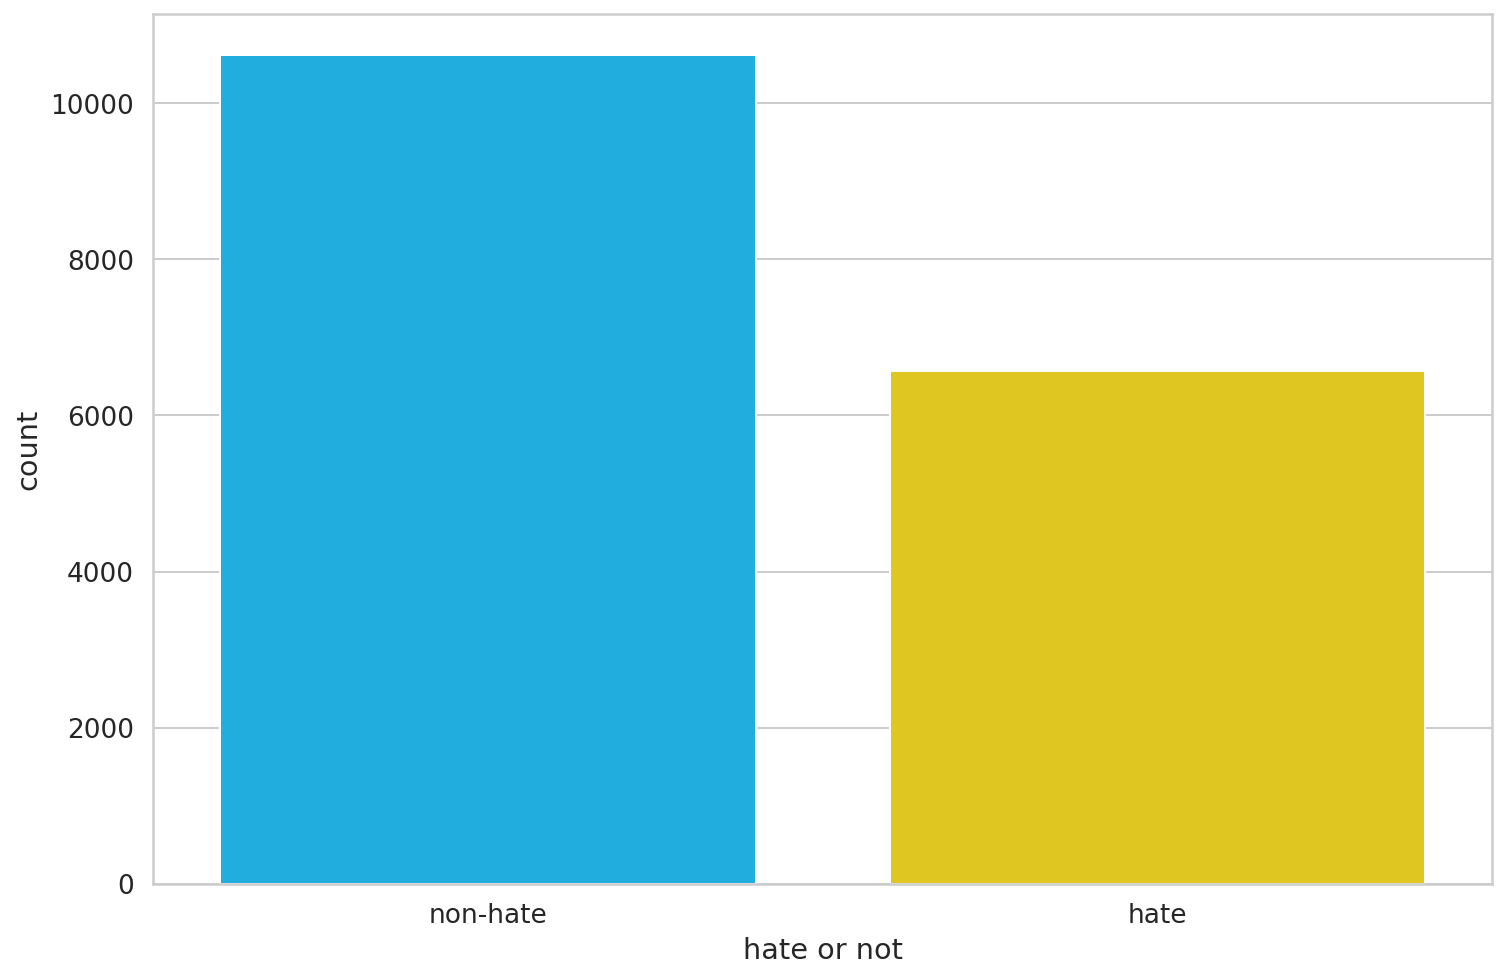

In [ ]:
ax = sns.countplot(df['is_hate'])
plt.xlabel('hate or not')
ax.set_xticklabels(class_names)

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

### Choosing Sequence Length

In [ ]:
token_lens = []

for txt in df['text']:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Token count')

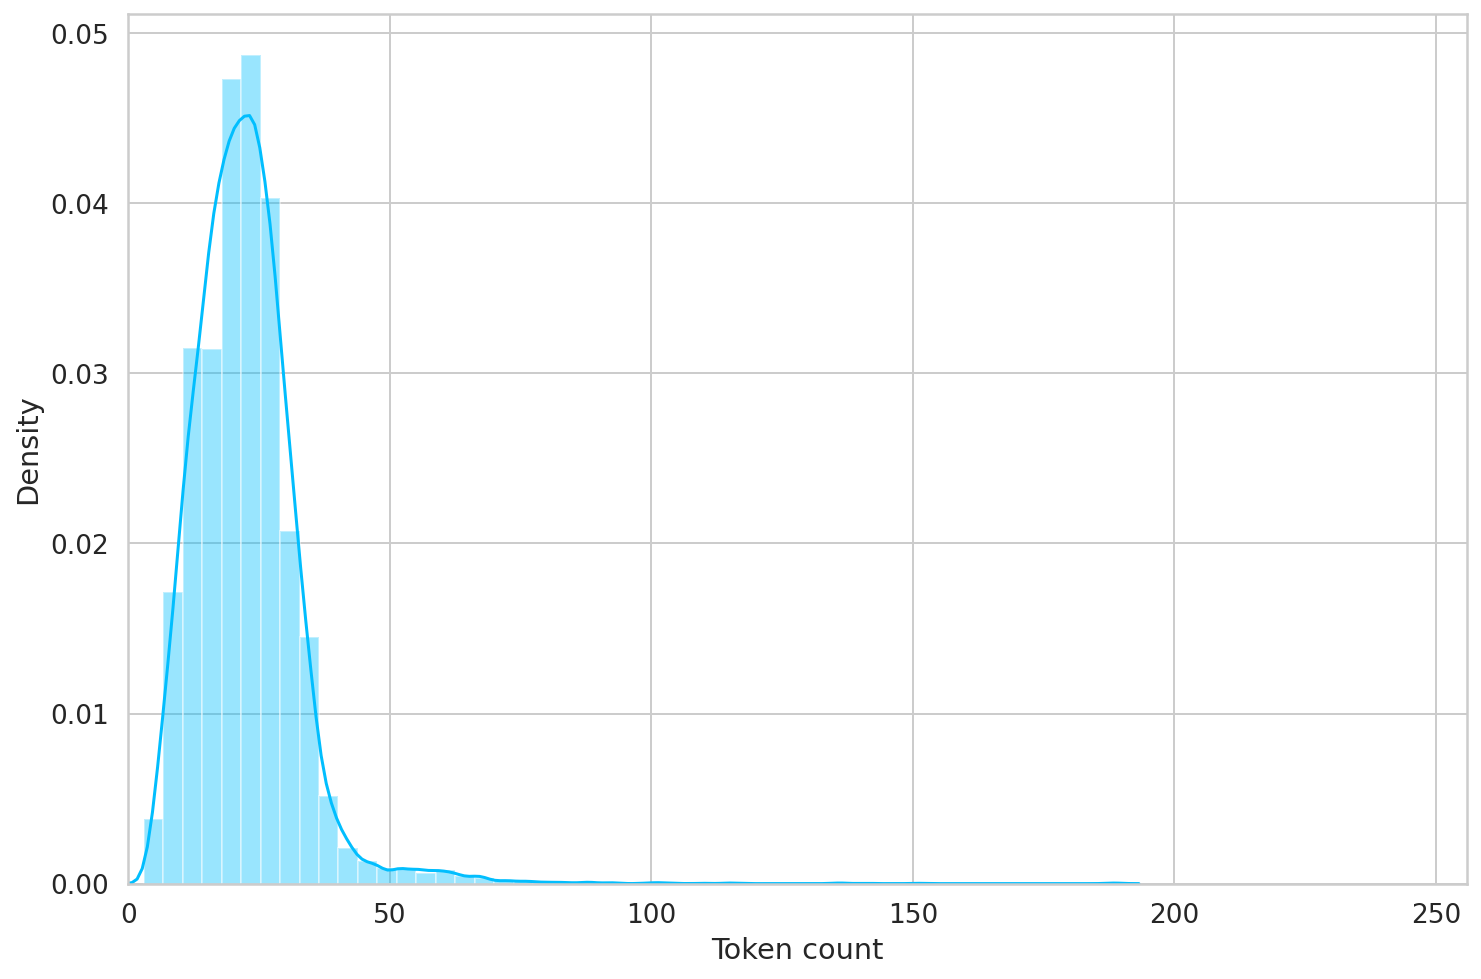

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256])
plt.xlabel('Token count')

In [ ]:
MAX_LEN = 256
alpha = 1

In [ ]:
class ImplicitHateDataset(Dataset):
    
    def __init__(self, text, targets, tokenizer, max_len):
        self.text = text
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, item):
        text = str(self.text[item])
        target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
df_train = pd.read_csv('real_dataset/implicit_hate_train.tsv', delimiter='\t')
df_val = pd.read_csv('real_dataset/implicit_hate_val.tsv', delimiter='\t')
df_test = pd.read_csv('real_dataset/implicit_hate_test.tsv', delimiter='\t')

In [ ]:
df_train['label'] = df_train['is_hate'].apply(to_int)
df_val['label'] = df_val['is_hate'].apply(to_int)
df_test['label'] = df_test['is_hate'].apply(to_int)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((17184, 4), (2148, 4), (2148, 4))

In [ ]:
# shortcut_pairs = pd.read_csv('runs/02/pairs/stormfront_pairs_id.csv')
shortcut_pairs = pd.read_csv('implicit_hate_shortcut_pairs.csv')
shortcut_pairs.head()

,avg_attn_score,num_occur,token_1,token_2,token_1_IDs,token_2_IDs
0,0.928514,13,privilege,white,14293,2317
1,0.882536,13,white,privilege,2317,14293
2,0.829038,21,white,men,2317,2273
3,0.784496,62,white,black,2317,2304
4,0.682639,17,white,non,2317,2512


In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = ImplicitHateDataset(
        text=df['text'].to_numpy(),
        targets=df['label'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=2
    )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
config = BertConfig.from_pretrained(PRE_TRAINED_MODEL_NAME, output_hidden_states=True, output_attentions=True)  

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, config=config)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
class ImplicitHateClassifier(nn.Module):

    def __init__(self, n_classes):
        super(ImplicitHateClassifier, self).__init__()
        config = BertConfig.from_pretrained(PRE_TRAINED_MODEL_NAME, output_hidden_states=True, output_attentions=True)  
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, config=config)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
    def forward(self, input_ids, attention_mask):
        output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        pooler_output = self.drop(output.pooler_output)
        return self.out(pooler_output), output

In [ ]:
model = ImplicitHateClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
EPOCHS = 3

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss(weight = torch.tensor([1.31151545, 0.80806561])).to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
    model = model.train()

    losses = []
    predictions = []
    real_values = []
    correct_predictions = 0
  
    for d in tqdm(data_loader):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs, _ = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )

        loss = 0

        if alpha != 0:
            for input_id in input_ids:
                for _, pairs in shortcut_pairs.iterrows():
                    if (pairs['token_1_IDs'] in input_id) and (pairs['token_2_IDs'] in input_id):
                        # print("regularize " + pairs['token_1'] + " and " + pairs['token_2'])
                        loss += pairs['avg_attn_score']

        _, preds = torch.max(outputs, dim=1)

        loss = alpha * loss + loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        predictions.extend(preds)
        real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()

    return correct_predictions.double() / n_examples, np.mean(losses), classification_report(real_values, predictions, target_names=class_names), f1_score(real_values, predictions, labels=1)

In [2]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    predictions = []
    real_values = []
    correct_predictions = 0
    co_atten_dict = defaultdict(list)

    # f = open("stormfront_errors.csv", mode="a")
    # writer = csv.writer(f)

    with torch.no_grad():
        for d in tqdm(data_loader):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs, full_outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
              )
            _, preds = torch.max(outputs, dim=1)

            postive_targets = targets.nonzero().flatten()

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

            atten_scores = full_outputs.attentions[11]
            atten_scores = torch.sum(atten_scores, 1)
            for batch_idx in range(atten_scores.shape[0]):
                for token_1_idx in range(atten_scores.shape[1]):
                    token_1 = tokenizer.convert_ids_to_tokens(d["input_ids"][batch_idx][token_1_idx][None])[0]
                    if token_1 == tokenizer.pad_token:
                        continue
                    for token_2_idx in range(atten_scores.shape[2]):
                        token_2 = tokenizer.convert_ids_to_tokens(d["input_ids"][batch_idx][token_2_idx][None])[0]
                        if token_2 == tokenizer.pad_token:
                            continue
                        # print(token_2)
                        co_atten_dict[(token_1, token_2)].append(atten_scores[batch_idx, token_1_idx, token_2_idx].item())

      
            # wrong_idx = np.where(preds.cpu() != targets.cpu())[0]
            # for i in wrong_idx:
            #   writer.writerow([d["text"][i], targets[i].item()])

            # print(text[preds != targets])
            # print(targets[preds != targets])

            predictions.extend(preds)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()

    # f.close()

    return correct_predictions.double() / n_examples, np.mean(losses), classification_report(real_values, predictions, target_names=class_names), f1_score(real_values, predictions, labels=1), co_atten_dict

In [3]:
def get_model_attn_scores(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    predictions = []
    real_values = []
    correct_predictions = 0
    pos_co_atten_dict = defaultdict(list)
    neg_co_atten_dict = defaultdict(list)

    # f = open("stormfront_errors.csv", mode="a")
    # writer = csv.writer(f)

    with torch.no_grad():
        for d in tqdm(data_loader):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs, full_outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            postive_targets = targets.nonzero().flatten()

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

            atten_scores = full_outputs.attentions[11]
            atten_scores = torch.sum(atten_scores, 1)
            for batch_idx in range(atten_scores.shape[0]):
                for token_1_idx in range(atten_scores.shape[1]):
                    token_1 = tokenizer.convert_ids_to_tokens(d["input_ids"][batch_idx][token_1_idx][None])[0]
                    if token_1 == tokenizer.pad_token:
                        continue
                    for token_2_idx in range(atten_scores.shape[2]):
                        token_2 = tokenizer.convert_ids_to_tokens(d["input_ids"][batch_idx][token_2_idx][None])[0]
                        if token_2 == tokenizer.pad_token:
                            continue
                        # print(token_2)
                        if targets[batch_idx] == 1:
                            pos_co_atten_dict[(token_1, token_2)].append(atten_scores[batch_idx, token_1_idx, token_2_idx].item())
                        else:
                            neg_co_atten_dict[(token_1, token_2)].append(atten_scores[batch_idx, token_1_idx, token_2_idx].item())

      
            # wrong_idx = np.where(preds.cpu() != targets.cpu())[0]
            # for i in wrong_idx:
            #   writer.writerow([d["text"][i], targets[i].item()])

            # print(text[preds != targets])
            # print(targets[preds != targets])

            predictions.extend(preds)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()

    # f.close()

    return correct_predictions.double() / n_examples, np.mean(losses), classification_report(real_values, predictions, target_names=class_names), f1_score(real_values, predictions, labels=1), (pos_co_atten_dict, neg_co_atten_dict)

Using those two, we can write our training loop. We'll also store the training history:

In [1]:
%%time

history = defaultdict(list)
best_accuracy = 0
early_stop_count = 0
prev_f1 = 0

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss, train_report, train_f1 = train_epoch(
        model,
        train_data_loader,    
        loss_fn, 
        optimizer, 
        device, 
        scheduler, 
        len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')
    print(train_report)

    val_acc, val_loss, val_report, val_f1, _ = eval_model(
        model,
        val_data_loader,
        loss_fn, 
        device, 
        len(df_val)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print(val_report)
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'implicit_hate_1_best_model_state.bin')
        best_accuracy = val_acc

  # if prev_f1 > val_f1:
  #   early_stop_count += 1;
  #   print(f'early stop count is now {early_stop_count}.')
  # else:
  #   early_stop_count = 0;
  #   print(f'early stop count has been reset to {early_stop_count}.')
  
  # if early_stop_count >= 5:
  #   print('early stop!')

NameError: name 'defaultdict' is not defined

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

Uncomment the next cell to load the model:

In [ ]:
# model = GHCClassifier(len(class_names))
# model.load_state_dict(torch.load('runs/01/model_states/ghc_best_model_state.bin'))
# model = model.to(device)

In [ ]:
# sample_txt = "Watch the water slowly rise with me, lads! Edge of your seat stuff. Watching for 'gators...  #Harvey   Water at 36.5' in Buffalo Bayou  https://youtu.be/cZGJZH6VW-k"
# inputs = tokenizer.encode_plus(
#   sample_txt,
#   max_length=256,
#   truncation=True,
#   add_special_tokens=True, # Add '[CLS]' and '[SEP]'
#   return_token_type_ids=False,
#   padding='max_length',
#   return_attention_mask=True,
#   return_tensors='pt',  # Return PyTorch tensors
# )

# # inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True)
# attention_mask = inputs['attention_mask'].to(device)
# input_ids = inputs['input_ids'].to(device)
# _, attention = model(input_ids, attention_mask=attention_mask)[-1]
# input_id_list = input_ids[0].tolist() # Batch index 0
# tokens = tokenizer.convert_ids_to_tokens(input_id_list)

In [ ]:
# head_view(attention, tokens)

## Evaluation

In [ ]:
val_acc, _, _, _, atten_scores = eval_model(
  model,
  val_data_loader,
  loss_fn,
  device,
  len(df_val)
)

val_acc.item()

In [ ]:
test_acc, _, _, _, atten_scores = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

In [ ]:
preds, mean_loss, class_report, f1, (pos_co_atten_dict, neg_co_atten_dict) = get_model_attn_scores(model, test_data_loader, loss_fn, device, len(df_test))

In [ ]:
f = open("implicit_hate_pos_attn_scores.csv", mode="a", encoding="utf-8")
writer = csv.writer(f)

f2 = open("implicit_hate_pos_attn_scores_concise.csv", mode="a", encoding="utf-8")
writer2 = csv.writer(f2)

f3 = open("implicit_hate_neg_attn_scores.csv", mode="a", encoding="utf-8")
writer3 = csv.writer(f3)

f4 = open("implicit_hate_neg_attn_scores_concise.csv", mode="a", encoding="utf-8")
writer4 = csv.writer(f4)

writer.writerow(["key", "avg_attn_score", "num_occur", "full_attn_score_list"])
writer2.writerow(["key", "avg_attn_score", "num_occur"])

writer3.writerow(["key", "avg_attn_score", "num_occur", "full_attn_score_list"])
writer4.writerow(["key", "avg_attn_score", "num_occur"])

pos_attn_scores, neg_attn_scores = pos_co_atten_dict, neg_co_atten_dict

for key, value in tqdm(pos_attn_scores.items()):
    writer.writerow([key, sum(value) / len(value), len(value), value])
    writer2.writerow([key, sum(value) / len(value), len(value)])

for key, value in tqdm(neg_attn_scores.items()):
    writer3.writerow([key, sum(value) / len(value), len(value), value])
    writer4.writerow([key, sum(value) / len(value), len(value)])


f.close()
f2.close()
f3.close()
f4.close()

In [4]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
f1_score(y_test, y_pred, labels=1)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

In [ ]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('Ground Truth')
    plt.xlabel('Prediction');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

### Example Prediction

In [ ]:
review_text = "I hate asians!"

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  truncation=True,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'prediction  : {class_names[prediction]}')